In [1]:
#! Author: Cholian Li  // Created at 20211228
# Contact: 
#! cholianli970518@gmail.com

# 注：代码由Cholian完成，使用权归蓝楹会组织与Cholian所有，未经许可，不得作为商用及他用。
# 如有refer，需添加以下信息：

# Author：Cholian
# Contact: cholianli970518@gmail.com

In [2]:
import backtrader as bt
import pandas as pd
import talib as ta # pip 有可能无法安装，使用 conda install -c conda-forge ta-lib 安装
import requests
import time
from urllib.parse import urljoin, urlencode

import datetime


# Functions

In [3]:
def time_format(TimeString):
    TimeString = datetime.datetime.strptime(TimeString, "%Y-%m-%d %H:%M:%S")
    TimeString = datetime.datetime.timestamp(TimeString)*1000
    
    return str(int(TimeString))

def start_end_time(startTime,interval,length = 1500):
#     Due to the limit of the api, we need a function to help cut a long time into small period.
#     The function input the start time and interval and return the start time and endtime. 
    
    startTime = int(startTime)/1000
    startTime = datetime.datetime.fromtimestamp(startTime)
    
#     unit 
    unit = interval
#     transfer the interval frequence
    if unit in ["1m","3m","5m","15m","30m"]:
        unit = 'm'
    elif unit in ["1h","2h","4h","6h","8h","12h"]:
        unit = 'hours'
    elif unit in ["1d","3d"]:
        unit = 'D'
    else:
        unit = 'W'
        
    endTime = pd.to_datetime(startTime)+pd.to_timedelta(length, unit = unit)

    startTime = datetime.datetime.timestamp(startTime)*1000
    endTime = datetime.datetime.timestamp(endTime)*1000
    
    return str(int(startTime)),str(int(endTime))


def klines(pair,startTime,endTime,interval,contractType='PERPETUAL'):
#    This function is aimed to gather the historical price data.    
    BASE_URL = 'https://fapi.binance.com'
    PATH = '/fapi/v1/continuousKlines'
   
    ''' 
    Contract type:

    PERPETUAL
    CURRENT_MONTH
    NEXT_MONTH
    CURRENT_QUARTER 当季交割合约
    NEXT_QUARTER 次季交割合约
    '''
    
    params = {
        'pair': pair,
        'contractType': contractType,
        'interval': interval,
        'startTime':startTime,
        'endTime':endTime,
        'limit':1500 # 500/1500 is the limit for each request
    }

    url = urljoin(BASE_URL, PATH)

    response = requests.get(url,params=params)

    data = response.json()
    data = pd.DataFrame(data)
#     change the cols
    col = ['Open time','Open','High','Low','Close','Volume','Close time','Quote asset volume','Number of trades',
       'Taker buy volume','Taker buy quote asset volume','Ignore']
    
    if not data.empty:
        data.columns = col
#       transfer the timestamp into time
        data['Open time'] = pd.to_datetime(data['Open time'],unit='ms',utc=True)
        data['Close time'] = pd.to_datetime(data['Close time'],unit='ms',utc=True)
        return data
    else:
        # print('No data')
        pass 

In [4]:
def Long_data(pair,startTime,endTime,now,interval,contractType):
    endTime = startTime 
    data = pd.DataFrame()

    while int(now)>int(endTime):

        [startTime,endTime] = start_end_time(startTime=startTime,interval=interval)
        d = klines(pair = pair,startTime=startTime,endTime=endTime,interval=interval,contractType=contractType)
        
        # log for the time
        # print(datetime.datetime.fromtimestamp(int(startTime)/1000),'finished!')
        startTime = endTime
        data = data.append(d)
        time.sleep(0.1)
    return data

In [5]:
def data_obatin(pair,interval,startTime):

    startTime = time_format(startTime)
    [startTime,endTime] = start_end_time(startTime=startTime,interval=interval)

    now = datetime.datetime.now()
    now = now.strftime("%Y-%m-%d %H:%M:%S")
    now = time_format(now)

    data = Long_data(pair,startTime,endTime,now,interval,contractType)
    
    # # adjust the datetime type
    data['Close time'] = data['Close time'].apply(lambda x:x.strftime('%Y-%m-%d %X'))

    # transfer the object to float
    data.iloc[:,1:6] = data.iloc[:,1:6].astype(float)
    data = data.iloc[:,[6,1,2,3,4,5]]
    data.iloc[:,0] = pd.to_datetime(data.iloc[:,0])
    data = data.set_index('Close time')
    
    return data
    
    

In [6]:
def future_data(pair,interval,contractType = 'PERPETUAL'):
    
    url_path = '/fapi/v1/continuousKlines'
    params = {
    'pair': pair,
    'contractType': contractType,
    'interval': interval,
    'limit':1500
    }

    response = send_public_request(url_path, params)

    col = ['Open time','Open','High','Low','Close','Volume','Close time','Quote asset volume','Number of trades',
        'Taker buy volume','Taker buy quote asset volume','Ignore']
    data = pd.DataFrame(response,columns=col)

    # adjust the datetime type
    data['Close time'] = pd.to_datetime(data['Close time'],unit='ms',utc=True).apply(lambda x:x.strftime('%Y-%m-%d %X'))

    # transfer the object to float
    data.iloc[:,1:6] = data.iloc[:,1:6].astype(float)
    data = data.iloc[:,[6,1,2,3,4,5]]
    data.iloc[:,0] = pd.to_datetime(data.iloc[:,0])
    data = data.set_index('Close time')
    
    return data

In [7]:
class BarAnalysis(bt.analyzers.Analyzer):
    # https://community.backtrader.com/topic/1194/formatting-of-output-csv-from-bt-writer/8
    def start(self):
        self.rets = list()

    def next(self):
        try:
            self.rets.append(
                [
                    self.datas[0].datetime.datetime(),
                    self.datas[0].open[0],
                    self.datas[0].high[0],
                    self.datas[0].low[0],
                    self.datas[0].close[0],
                    self.datas[0].volume[0],
                    self.strategy.getposition().size,
                    self.strategy.broker.getvalue(),
                    self.strategy.broker.getcash(),
                ]
            )
        except:
            pass

    def get_analysis(self):
        return self.rets

In [12]:
# Create a Stratey
class TestStrategy(bt.Strategy):
    params = (
        ('line_a', None),
        ('line_b',None),
    )

    def log(self, txt, dt=None):
        
        pass
    
        # ''' Logging function for this strategy'''
        # dt = dt or self.datas[0].datetime.datetime(0)
        # print('%s, %s' % (dt, txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        
        # To keep track of pending orders
        self.order = None
        self.buyprice = None
        self.buycomm = None
        
        # Add a EMA indicator
        self.ema_a = bt.talib.EMA(self.dataclose, timeperiod=self.params.line_a,plotname = 'ema_a',)
        self.ema_b = bt.talib.EMA(self.dataclose, timeperiod=self.params.line_b,plotname = 'ema_b',)
        
        
    def notify_order(self, order):
        
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))
                
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
                
            elif order.issell() : # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))

            elif order.isclose():
                self.log('Order closed EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))
            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None
        
   
    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))     

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])
        self.log(f'EMA_a: {self.ema_a[0]},EMA_b: {self.ema_b[0]},')
        
        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return
        
        # If the Fast line cross over the slow line
        if self.ema_a[0] > self.ema_b[0]:
            
            # If there is already an order in a position
            if self.position:
                
                # If is has an short order, we should transfer the short position to the long position
                if self.position.size < 0:
                          
                    # close the previous position, e.g: long
                    self.close()
                    # buyin a new long position
                    self.buy()
                    self.log('Short --> Long  CREATE, %.2f' % self.dataclose[0])
                    
            # if there is no order in a position, we should order the position 
            # according to the current EMA singal, here we assumed the long position
            else:
                self.buy()
                self.log('Long CREATE, %.2f' % self.dataclose[0])
             
        #    Opposite to above
        elif self.ema_a[0] < self.ema_b[0]:
            
            if self.position:
                if self.position.size > 0:
                    self.close()
                    self.sell()
                    self.log('Long --> Short  CREATE, %.2f' % self.dataclose[0])
                    
            else:
                self.sell()
                self.log('Short CREATE, %.2f' % self.dataclose[0])
                
                
def runstart(line_a,line_b,data_ts,startCash,stake,commission):
    
    cerebro = bt.Cerebro()

    # self-define the observers
    cerebro = bt.Cerebro(stdstats=False)
    
    # TODO // Add observers
    cerebro.addobserver(bt.observers.Broker)
    
    # TODO // Add a Data
    dataframe = data_ts
    
    # Pass it to the backtrader datafeed and add it to the cerebro
    data = bt.feeds.PandasData(dataname=dataframe)
    cerebro.adddata(data)
    
    # TODO // Add a strategy
    cerebro.addstrategy(TestStrategy,line_a = line_a,line_b=line_b)
    
    # TODO // Analyzer
    cerebro.addanalyzer(BarAnalysis,_name = "bar_data")
    
    # TODO // Cash
    cerebro.broker.setcash(startCash)

    # TODO // Add a FixedSize sizer according to the stake
    cerebro.addsizer(bt.sizers.FixedSize, stake=stake)
    
    # TODO // Set the commission - 0.1% ... divide by 100 to remove the %
    cerebro.broker.setcommission(commission=commission)

    # TODO // Run over everything
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    results = cerebro.run(tradehistory=True)
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # TODO // Plot the result
    cerebro.plot()
    
    # TODO // result
    strats = results[0]
    
    bar_data_res = strats.analyzers.bar_data.get_analysis()
    analy_result = pd.DataFrame(bar_data_res)
    analy_result.columns = ['date', 'open', 'high', 'low', 'close', 'volume', 'position', 'value', 'cash']

    return analy_result


# Test data

In [9]:
# # uncomment to obtain the testing backtest return.

# stake = 0.005
# commission = 0.004
# startCash = 100.0

# line_a = 36
# line_b = 60

# data_ts = pd.read_csv('回测/BTC_6h_test.csv',index_col=0,parse_dates=True)
# analy_result = runstart(line_a,line_b,data_ts,startCash,stake,commission)
# analy_result.to_csv('回测/Test_return.csv',index =False)

# (analy_result.iloc[-1,7]-startCash) # return
# (analy_result.iloc[-1,7]-startCash)/analy_result.iloc[:,7].std() #sharp ratio
# analy_result.iloc[:,7].min()/startCash -1 # max drowdown

# Daily return

Starting Portfolio Value: 100.00
Final Portfolio Value: 276.07


<IPython.core.display.Javascript object>


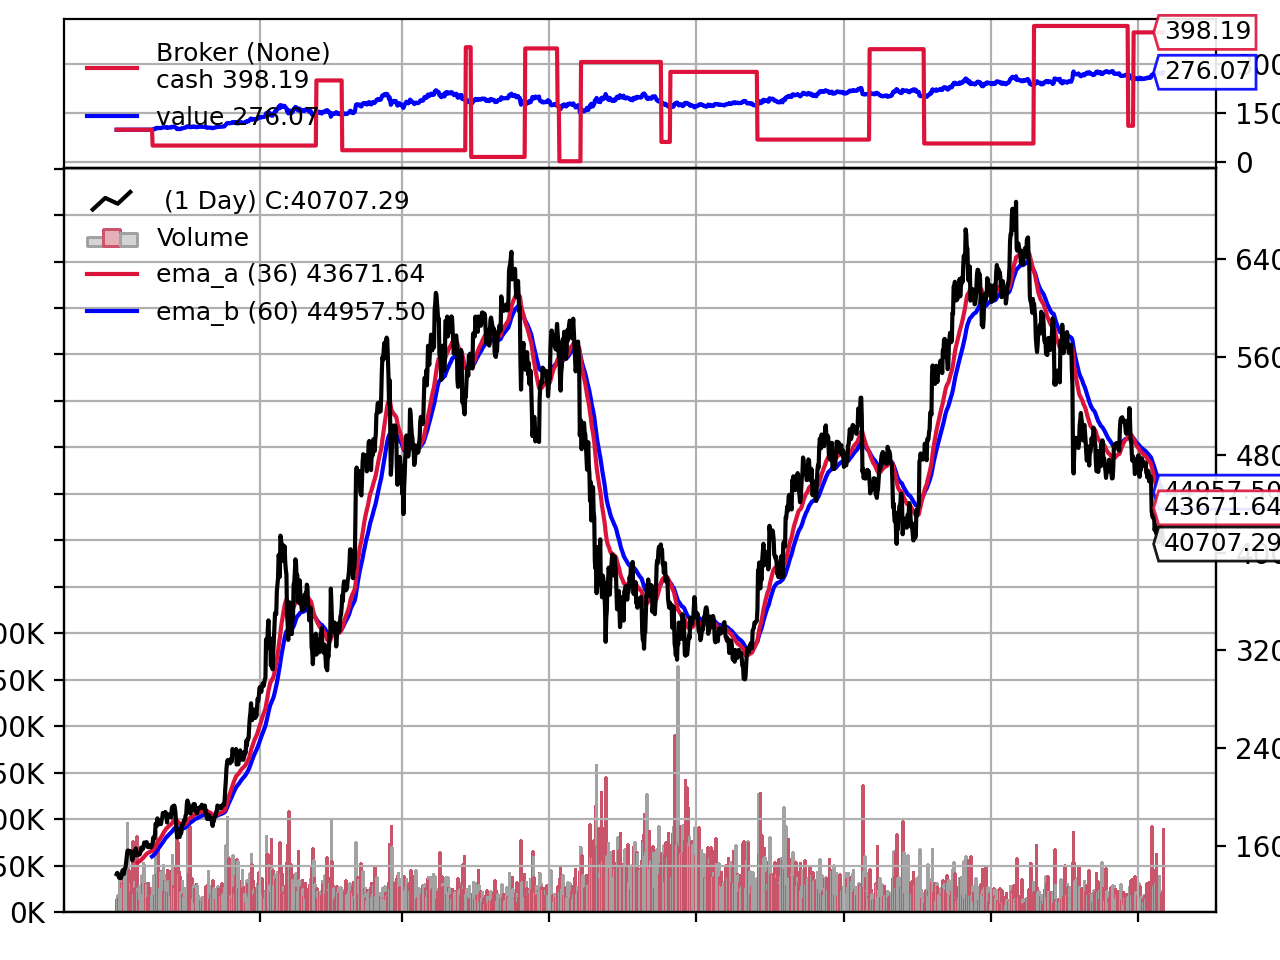

In [14]:
pair = 'BTCUSDT'
interval = '6h'
contractType = 'PERPETUAL'
startTime = '2020-11-01 00:00:00'
stake = 0.003
commission = 0.004
startCash = 100.0

line_a = 36
line_b = 60

data_ts = data_obatin(pair,interval,startTime)
analy_result = runstart(line_a,line_b,data_ts,startCash,stake,commission)

In [11]:
today = datetime.datetime.now().strftime("%Y%m%d")
analy_result.to_csv(f'输出/Return_{today}.csv',index=False)

In [141]:
analy_result = analy_result.iloc[60:,]

# plot

In [32]:
import seaborn as sns

In [142]:
analy_result.head()

,date,open,high,low,close,volume,position,value,cash
60,2021-11-16 11:59:59,60979.57,61320.58,58397.14,60593.99,158652.749,0.0,100.0,100.0
61,2021-11-16 17:59:59,60593.87,61423.70,60031.99,60490.71,81748.907,0.0,100.0,100.0
62,2021-11-16 23:59:59,60490.70,61171.76,59143.03,60106.03,72352.652,0.0,100.0,100.0
63,2021-11-17 05:59:59,60106.03,60470.10,58571.42,59630.58,86502.636,0.0,100.0,100.0
64,2021-11-17 11:59:59,59630.58,60848.85,58336.68,60769.01,98801.718,0.0,100.0,100.0


In [143]:
analy_result.iloc[-1,7]

155.49293959999997

<IPython.core.display.Javascript object>


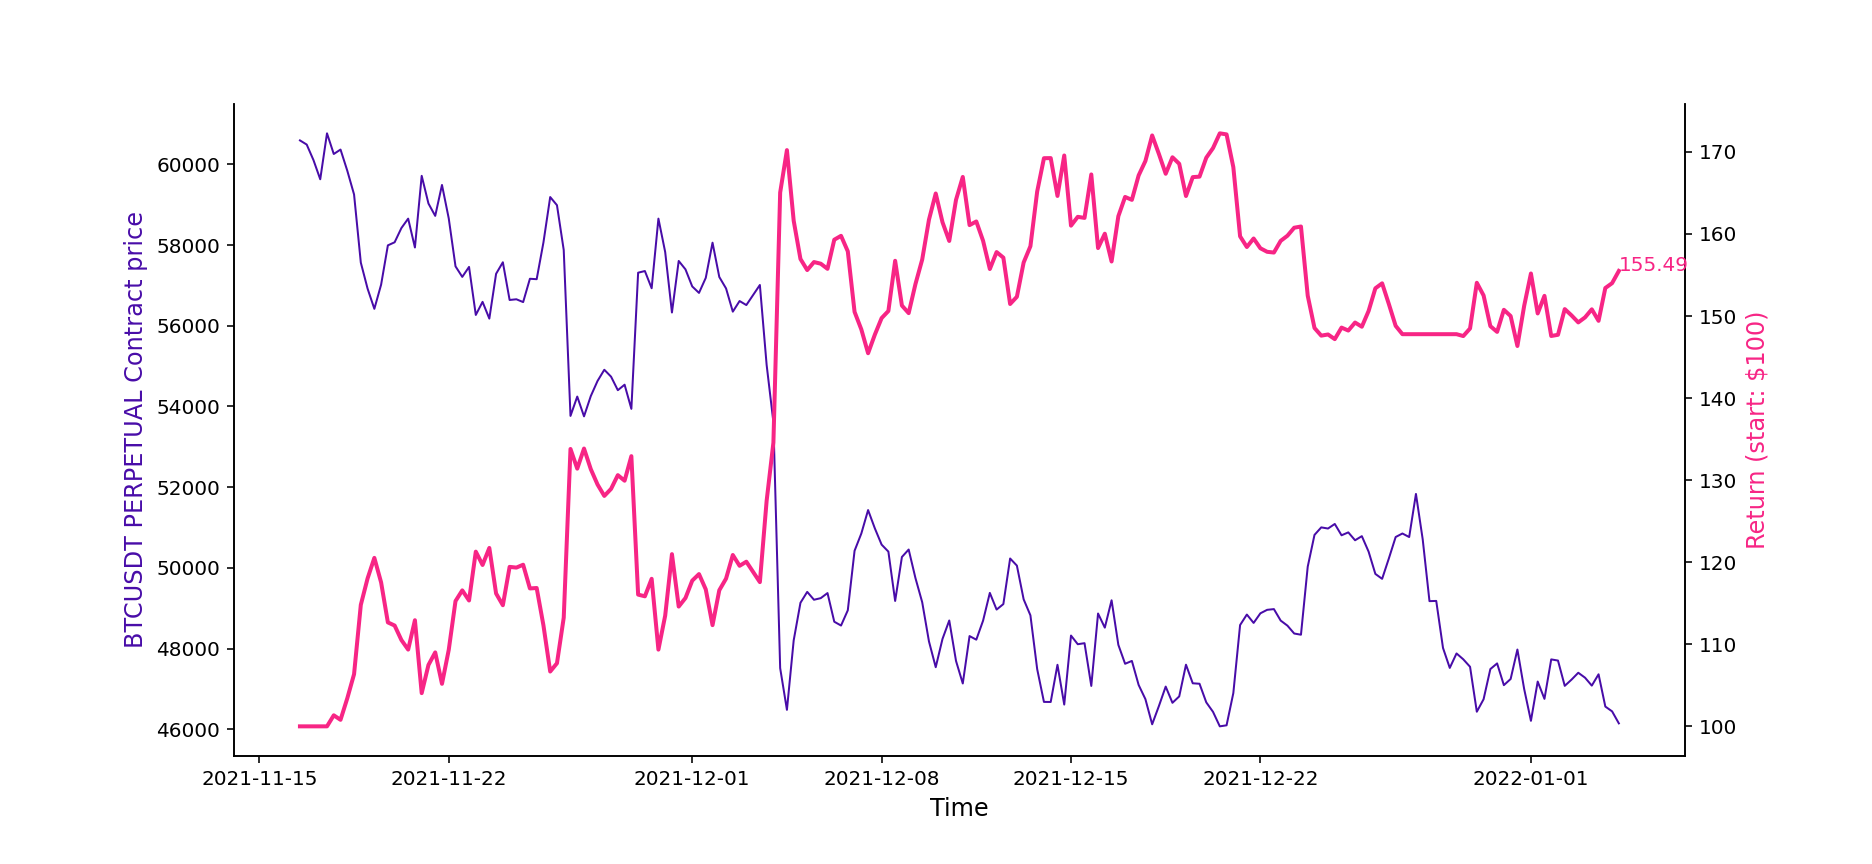

In [145]:
fig, ax1 = plt.subplots(figsize = (13,6),facecolor='white')

ax2 = ax1.twinx()

ax1.plot(analy_result['date'], analy_result.close,c = "#480ca8",linewidth=1.0)
ax2.plot(analy_result['date'], analy_result.value,c = '#f72585',linewidth=2.0)


ax1.set_xlabel('Time',fontsize=12)
ax1.set_ylabel('BTCUSDT PERPETUAL Contract price', color='#480ca8',fontsize=12)
ax2.set_ylabel('Return (start: $100)', color='#f72585',fontsize=12)

ax1.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)


plt.text(analy_result.iloc[-1,0], analy_result.iloc[-1,7], round(analy_result.iloc[-1,7],2),color = '#f72585')

plt.show()
plt.savefig('输出/Return_plot.png')